# Testing OptimizedGenerator
The OptimizedGenerator uses [numba](https://numba.pydata.org/) to accelerate the simulation of random walks and the calculation of random walk visitation probabilities. The HigherOrderPathGenerator includes an OptimizedGenerator, and several HON embeddings' train methods include a parameter `use_numba`, which by default enables the acceleration.

This notebook verifies the OptimizedGenerator.
* OptimizedGenerator is indeed faster
* Exactly the same embedding for HON_DeepWalk_Embedding and HON_GraRep_Embedding
* Small numerical differences for HON_NetMF_Embedding's PMI and embeddig

In [1]:
from HigherOrderPathGenerator import *
from SyntheticNetworks import create_lattice_2nd_order_dynamic
from Embedding import HON_DeepWalk_Embedding, HON_NetMF_Embedding, HON_GraRep_Embedding
from OptimizedGenerator import OptimizedGenerator, create_OptimizedGenerator, debug_OptimizedGenerator
import collections
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
size = 10
gen = create_lattice_2nd_order_dynamic(size,0.5)

* cannot pass `ABCHigherOrderPathGenerator` to `OptimizedGenerator` use `create_OptimizedGenerator()` instead
* Numba does not support individual RandomState instances [Numba random](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html#random)
* [Callback into the Python Interpreter from within JIT’ed code](http://numba.pydata.org/numba-doc/latest/user/withobjmode.html): `numba.objmode`

In [3]:
ogen = create_OptimizedGenerator(gen)
debug_OptimizedGenerator(gen, ogen)

,source_path,next_node,next_path,prob,cumulated_prob,source_paths_idx,next_node_idx,next_path_idx
0,"(0-0,)",1-0,"(0-0, 1-0)",0.500000,0.500000,0,10,101
1,"(0-0,)",0-1,"(0-0, 0-1)",0.500000,1.000000,0,1,100
2,"(0-1,)",1-1,"(0-1, 1-1)",0.333333,0.333333,1,11,104
3,"(0-1,)",0-2,"(0-1, 0-2)",0.333333,0.666667,1,2,103
4,"(0-1,)",0-0,"(0-1, 0-0)",0.333333,1.000000,1,0,102
...,...,...,...,...,...,...,...,...
1783,None,9-5,"(9-5,)",0.008333,0.969444,460,95,95
1784,None,9-6,"(9-6,)",0.008333,0.977778,460,96,96
1785,None,9-7,"(9-7,)",0.008333,0.986111,460,97,97
1786,None,9-8,"(9-8,)",0.008333,0.994444,460,98,98


## Verify RNG

In [4]:
random_seed=0
rng = np.random.default_rng(random_seed)
rng.random((2,3))

array([[0.63696169, 0.26978671, 0.04097352],
       [0.01652764, 0.81327024, 0.91275558]])

In [5]:
rng = np.random.default_rng(random_seed)
print(rng.random(3))
print(rng.random(3))

[0.63696169 0.26978671 0.04097352]
[0.01652764 0.81327024 0.91275558]


In [6]:
rng = np.random.default_rng(random_seed)
print(rng.random(1))
print(rng.random(1))

[0.63696169]
[0.26978671]


## Verify random_walks

In [7]:
random_seed=1
num_steps=4
start_list = [('0-0',), ('1-1',), ('2-2','1-2')]
rng = np.random.default_rng(random_seed)
gen.random_walks(start_list, num_steps, rng, include_start=True)

[('0-0', '0-1', '0-0', '1-0', '1-1'),
 ('1-1', '1-2', '2-2', '2-1', '3-1'),
 ('2-2', '1-2', '1-3', '0-3', '0-2', '0-3')]

In [8]:
rng = np.random.default_rng(random_seed)
def random_walks_py(start_list, num_steps, rng):
    walks = list()
    for start in start_list:
        walks.append(gen.random_walk(start=start, num_steps=num_steps, rng=rng))
    return walks
random_walks_py(start_list, num_steps, rng)

[('0-0', '0-1', '0-0', '1-0', '1-1'),
 ('1-1', '1-2', '2-2', '2-1', '3-1'),
 ('2-2', '1-2', '1-3', '0-3', '0-2', '0-3')]

In [9]:
num_walks2=500
num_steps2=10
random_seed = 0
rng = np.random.default_rng(random_seed)
start_list2 = rng.choice(np.array(gen.source_paths, dtype=object), size=num_walks2)

In [10]:
rng = np.random.default_rng(random_seed)
%timeit gen.random_walks(start_list2, num_steps2, rng)

1.77 ms ± 30.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
rng = np.random.default_rng(random_seed)
%timeit random_walks_py(start_list2, num_steps2, rng)

19.5 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Verify walk_probs(_df)

In [12]:
num_steps=1
pairwise=True

In [13]:
gen.walk_probs_df(num_steps=num_steps, pairwise=pairwise)

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,9-0,9-1,9-2,9-3,9-4,9-5,9-6,9-7,9-8,9-9
"('0-0',)",0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"('0-1',)",0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"('0-2',)",0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"('0-3',)",0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"('0-4',)",0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"('9-5',)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000
"('9-6',)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000
"('9-7',)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000
"('9-8',)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333


In [14]:
# see disp_pmi_row in Plots_ExpVis_synth.ipynb
def disp_probs_row(gen, num_steps=num_steps, node='2-2', title=None, vmax=None, figureargs=dict(dpi=200)):
    probs = gen.walk_probs(num_steps=num_steps, pairwise=True, aggregate_steps=True)
    row = np.resize(probs[gen._source_paths_dict[(node,)]], (size,size)).T
    fig = plt.figure(**figureargs)
    ax = sns.heatmap(row, annot=True, cmap=plt.cm.Blues, ax=fig.gca(), vmin=0, vmax=vmax)
    ax.invert_yaxis()
    if title is not None:
        fig.suptitle(title)
    return fig

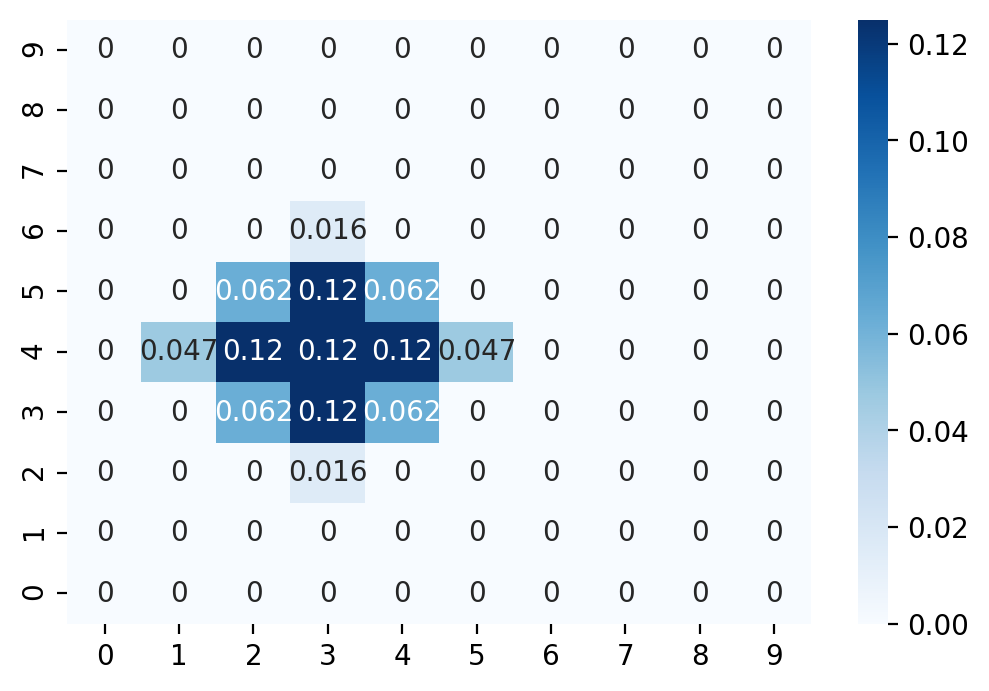

In [15]:
# checking positions
node='3-4'
num_steps=2
disp_probs_row(gen, num_steps=num_steps, node=node)
None

In [16]:
probs = gen.walk_probs_df(num_steps=num_steps, pairwise=True).loc[str((node,))]
probs[probs>0]

1-4    0.046875
2-3    0.062500
2-4    0.125000
2-5    0.062500
3-2    0.015625
3-3    0.125000
3-4    0.125000
3-5    0.125000
3-6    0.015625
4-3    0.062500
4-4    0.125000
4-5    0.062500
5-4    0.046875
Name: ('3-4',), dtype: float64

In [17]:
def walk_probs_py(num_steps, pairwise=True):
    source_list = gen.source_paths_len1 if pairwise else gen.source_paths
    idx = gen._target_nodes_dict
    PMI = np.zeros(shape=(len(source_list), len(gen.target_nodes)))
    for iu,u in enumerate(source_list):
        paths = {u: 1/num_steps}
        for _ in range(num_steps):
            paths_new = collections.defaultdict(float)
            for source,source_prob in paths.items():
                for _,next_node,prob in gen.transition_probs(source):
                    prob_new = source_prob * prob
                    PMI[iu,idx[next_node]] += prob_new
                    source_new = gen.find_rule_key((*source, next_node))
                    paths_new[source_new] += prob_new
            paths = paths_new
    return PMI

In [18]:
x = gen.walk_probs(num_steps, pairwise)
y = walk_probs_py(num_steps, pairwise)
np.abs(x-y).max()

0.0

In [19]:
num_steps3=10
rng = np.random.default_rng(random_seed)
%timeit gen.walk_probs(num_steps3, pairwise)

15.3 ms ± 62.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
rng = np.random.default_rng(random_seed)
%timeit walk_probs_py(num_steps3, pairwise)

444 ms ± 8.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Verify PMI and embedding

In [21]:
netmf_para = dict(gen=gen, dimension=16, pairwise=False)
netmf_train_para = dict(window_size=10, negative=1, optimized=True)
emb_H1 = HON_NetMF_Embedding(**netmf_para)
%time emb_H1.train(**netmf_train_para, use_numba=False)

Wall time: 2.28 s


In [22]:
emb_H2 = HON_NetMF_Embedding(**netmf_para)
%time emb_H2.train(**netmf_train_para, use_numba=True)

Wall time: 86.8 ms


In [23]:
np.abs(emb_H1.PMI.values-emb_H2.PMI.values).max()

1.4210854715202004e-14

In [24]:
np.abs(emb_H1.source.embedding.values-emb_H2.source.embedding.values).max()

2.0788926136106056e-14

In [25]:
grarep_para = dict(gen=gen, dimension=16, num_steps=4, pairwise=False, neg_stationary=False)
grarep_train_para = dict(negative=1, normalize=True)
emb_G1 = HON_GraRep_Embedding(**grarep_para)
%time emb_G1.train(**grarep_train_para, use_numba=False)

Wall time: 201 ms


In [26]:
emb_G2 = HON_GraRep_Embedding(**grarep_para)
%time emb_G2.train(**grarep_train_para, use_numba=True)

Wall time: 36.9 ms


In [27]:
for step in range(1, grarep_para['num_steps']+1):
    print(step, np.abs(emb_G1.PMI(step).values-emb_G2.PMI(step).values).max())

1 0.0
2 0.0
3 0.0
4 0.0


In [28]:
np.abs(emb_G1.source.embedding.values-emb_G2.source.embedding.values).max()

0.0

In [29]:
deepwalk_para = dict(gen=gen, dimension=16, reuse_walks=True)
deepwalk_train_para = dict(random_seed=0)
emb_D1 = HON_DeepWalk_Embedding(**deepwalk_para)
%time emb_D1.train(**deepwalk_train_para, use_numba=False)

Wall time: 5.07 s


In [30]:
emb_D2 = HON_DeepWalk_Embedding(**deepwalk_para)
%time emb_D2.train(**deepwalk_train_para, use_numba=True)

Wall time: 1.86 s


In [31]:
np.abs(emb_D1.source.embedding.values-emb_D2.source.embedding.values).max()

0.0